In [ ]:
!pip install langchain-openai yfinance matplotlib PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime, timedelta
from langchain_openai import ChatOpenAI
from pypfopt import risk_models, expected_returns, BlackLittermanModel, EfficientFrontier, black_litterman
from scipy.optimize import minimize

In [ ]:
#Initializes OpenAI LLM Model
def initialize_llm(api_key):
    llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=api_key)
    return llm

In [ ]:
# Calculate start and end dates based on the number of years from today
def calculate_date_range(years):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=years * 365)
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

In [ ]:
# Get LLM response based on a given prompt
def get_llm_response(llm, prompt):
    response = llm(prompt)
    display(Markdown(response.content))
    return response.content

In [ ]:
def download_data(tickers, start_date, end_date):
    return yf.download(tickers, start=start_date, end=end_date)

In [ ]:
def calculate_and_plot_rsi(ticker, start_date, end_date, window=14):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', label='Overbought')
    plt.axhline(30, color='green', linestyle='--', label='Oversold')
    plt.title(f'RSI of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def calculate_and_plot_bollinger_bands(ticker, start_date, end_date, window=20):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['Upper Band'] = data['SMA'] + 2 * data['Close'].rolling(window=window).std()
    data['Lower Band'] = data['SMA'] - 2 * data['Close'].rolling(window=window).std()

    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Closing Price')
    plt.plot(data.index, data['Upper Band'], label='Upper Band', linestyle='--', color='red')
    plt.plot(data.index, data['Lower Band'], label='Lower Band', linestyle='--', color='green')
    plt.fill_between(data.index, data['Lower Band'], data['Upper Band'], color='grey', alpha=0.1)
    plt.title(f'Bollinger Bands of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def plot_closing_price(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)

    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Closing Price', color='blue')
    plt.title(f'Closing Price of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def calculate_and_plot_pe_ratio(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    eps = stock.info.get('trailingEps')

    if eps and eps > 0:
        data['P/E Ratio'] = data['Close'] / eps
        plt.figure(figsize=(10, 6))
        plt.plot(data.index, data['P/E Ratio'], label='P/E Ratio', color='orange')
        plt.title(f'P/E Ratio of {ticker}')
        plt.xlabel('Date')
        plt.ylabel('P/E Ratio')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"P/E Ratio for {ticker} could not be calculated (EPS unavailable).")


In [ ]:
def plot_beta(tickers):
    beta_values = {}

    for ticker in tickers:
        try:
            ticker_info = yf.Ticker(ticker).info
            beta = ticker_info.get('beta')

            if beta is not None:
                beta_values[ticker] = beta
            else:
                print(f"Beta value for {ticker} is not available.")
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

    plt.figure(figsize=(10, 6))
    plt.bar(beta_values.keys(), beta_values.values(), color='skyblue')
    plt.axhline(y=1, color='red', linestyle='--', label='Market Beta (1)')
    plt.title('Beta Values of Stocks', fontsize=16)
    plt.xlabel('Stocks', fontsize=14)
    plt.ylabel('Beta', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
# Calculate all the KPI's for a list of stocks over a period of time

def calculate_all_kpis(tickers, start_date, end_date):
    kpi_data = {}

    for ticker in tickers:
        try:
            # Fetch historical data
            stock = yf.Ticker(ticker)
            data = stock.history(start=start_date, end=end_date)

            if data.empty:
                print(f"No data available for {ticker}.")
                continue

            # Closing Price
            closing_price = data['Close']

            # RSI Calculation
            delta = closing_price.diff()
            gain = delta.where(delta > 0, 0).rolling(window=14).mean()
            loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))

            # Bollinger Bands Calculation
            sma = closing_price.rolling(window=20).mean()
            std = closing_price.rolling(window=20).std()
            upper_band = sma + 2 * std
            lower_band = sma - 2 * std

            # P/E Ratio Calculation
            eps = stock.info.get('trailingEps')
            pe_ratio = closing_price / eps if eps and eps > 0 else None

            # Beta Calculation
            beta = stock.info.get('beta')

            # Store KPIs in dictionary
            kpi_data[ticker] = {
                'Closing Price': closing_price,
                'RSI': rsi,
                'Bollinger Bands': {
                    'SMA': sma,
                    'Upper Band': upper_band,
                    'Lower Band': lower_band
                },
                'P/E Ratio': pe_ratio,
                'Beta': beta
            }

        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    return kpi_data


In [ ]:
# Open AI API Key
api_key = "use your api-key"

# Inputs

In [ ]:
llm = initialize_llm(api_key = api_key)

In [ ]:
# The number of years for which the analysis is done
years = 2 # 2 years

In [ ]:
#List of assets to analyze
assets = [
    "Apple (AAPL)",
    "Amazon (AMZN)",
    "Bitcoin (BTC-USD)",
    "Alphabet (GOOGL)",
    "Meta (META)",
    "Microsoft (MSFT)",
    "Nvidia (NVDA)",
    "S&P 500 index (SPY)",
    "Tesla (TSLA)"
]



In [ ]:
# Define query for the ticker
query = f"""
fetch me the tickers from the following assets: {assets}
The ouput must be sorted alphabetically by the ticker and it should look like this:
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
"""

In [ ]:
# Invoke Response from LLM
get_llm_response(llm = llm, prompt = query)

<ipython-input-6-977826434acc>:3: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(prompt)


Certainly! Here is the list of tickers sorted alphabetically:

```python
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
```

"Certainly! Here is the list of tickers sorted alphabetically:\n\n```python\ntickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']\n```"

In [ ]:
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']

In [ ]:
# Calculate the start and end dates
start_date, end_date = calculate_date_range(years)

In [ ]:
#Fetch historical data from yfinance
data = yf.download(tickers, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  9 of 9 completed


Price            Close                                                  \
Ticker            AAPL       AMZN       BTC-USD      GOOGL        META   
Date                                                                     
2023-01-15         NaN        NaN  20880.798828        NaN         NaN   
2023-01-16         NaN        NaN  21169.632812        NaN         NaN   
2023-01-17  134.525330  96.050003  21161.519531  90.960266  134.844894   
2023-01-18  133.802948  95.459999  20688.781250  90.790878  132.513824   
2023-01-19  133.862320  93.680000  21086.792969  92.713913  135.631912   

Price                                                            High  ...  \
Ticker            MSFT       NVDA         SPY        TSLA        AAPL  ...   
Date                                                                   ...   
2023-01-15         NaN        NaN         NaN         NaN         NaN  ...   
2023-01-16         NaN        NaN         NaN         NaN         NaN  ...   
2023-01-17  236.469284  17.689137  386.852661  131.490005  135.861272  ...   
2023-01-18  232.002563  17.364368  380.744995  128.779999  137.167560  ...   
2023-01-19  228.185211  16.752817  377.973236  127.169998  134.832117  ...   

Price             Open      Volume                                        \
Ticker            TSLA        AAPL        AMZN       BTC-USD       GOOGL   
Date                                                                       
2023-01-15         NaN         NaN         NaN  1.929841e+10         NaN   
2023-01-16         NaN         NaN         NaN  2.679249e+10         NaN   
2023-01-17  125.699997  63646600.0  72755000.0  2.499998e+10  32602400.0   
2023-01-18  136.559998  69672800.0  79570400.0  3.000563e+10  29116700.0   
2023-01-19  127.260002  58280400.0  69002700.0  2.115285e+10  37000400.0   

Price                                                                     
Ticker            META        MSFT         NVDA         SPY         TSLA  
Date                                                                      
2023-01-15         NaN         NaN          NaN         NaN          NaN  
2023-01-16         NaN         NaN          NaN         NaN          NaN  
2023-01-17  21147600.0  29831300.0  511102000.0  62677300.0  186477000.0  
2023-01-18  20215500.0  30028700.0  439624000.0  99632300.0  195680300.0  
2023-01-19  28625200.0  28623000.0  452932000.0  86958900.0  170291900.0  

[5 rows x 45 columns]

# Outputs

# Relative Strength Index (RSI)

**What is it?** RSI is a momentum oscillator that measures the speed and change of price movements.

**How to interpret?** It ranges from 0 to 100, with values above 70 indicating overbought conditions and a sell opportunity. An RSI below 30 indicates oversold conditions and a potential buy opportunity.

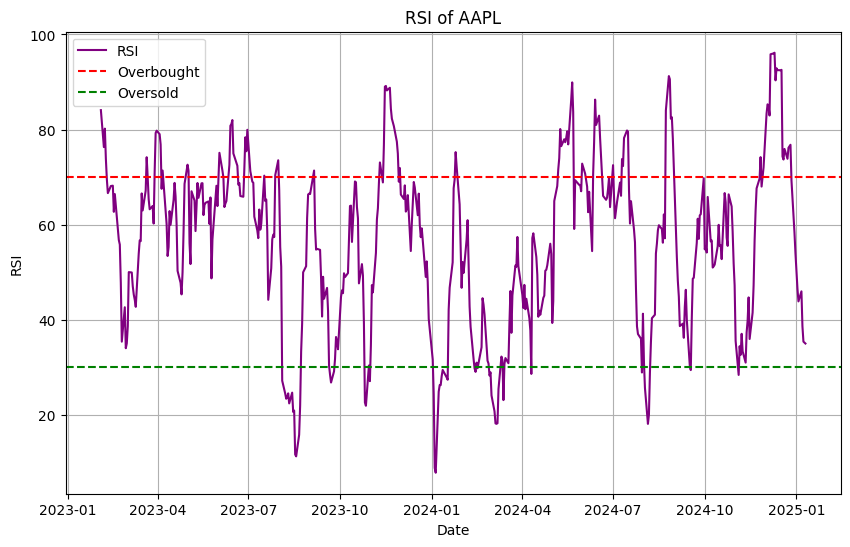

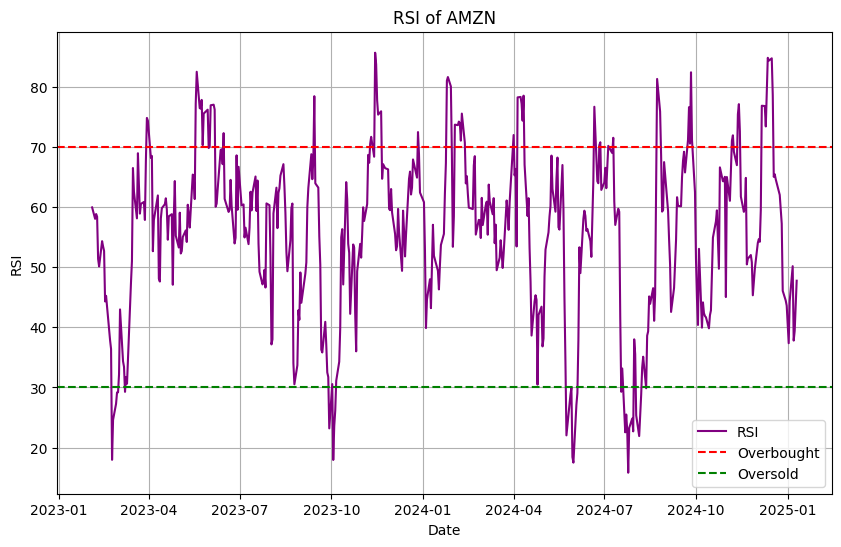

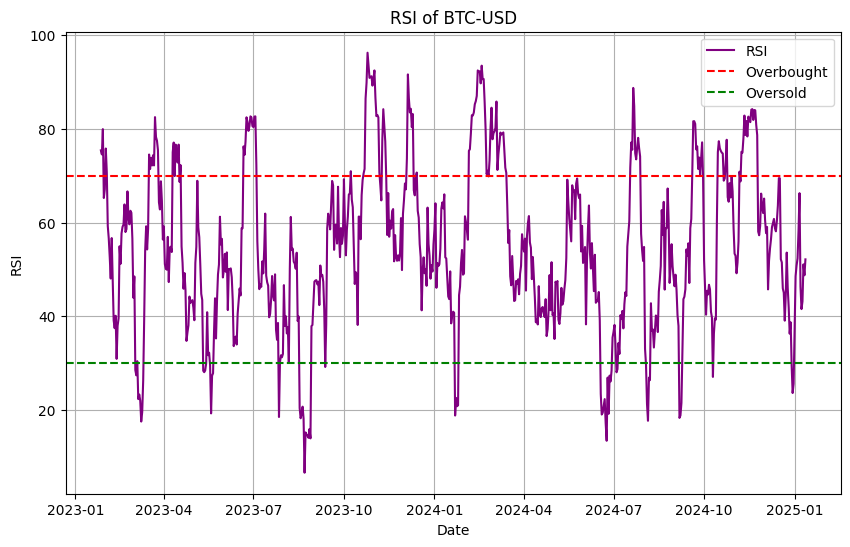

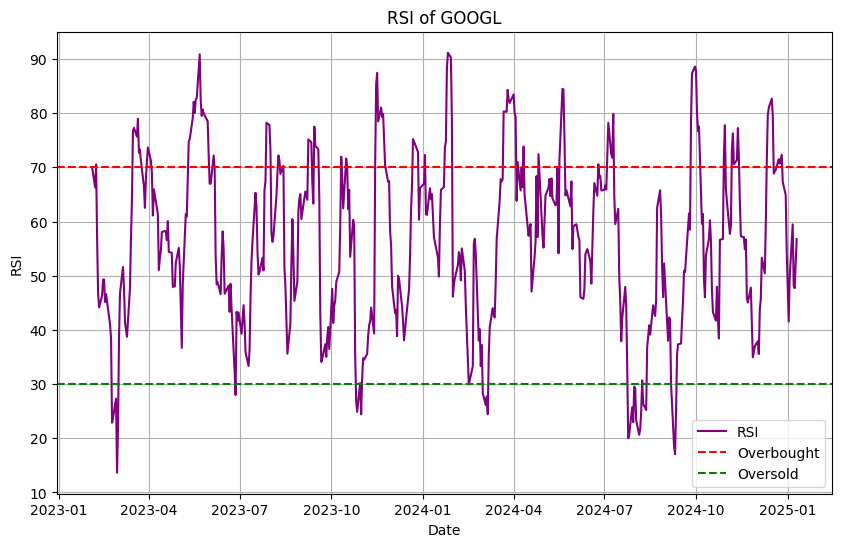

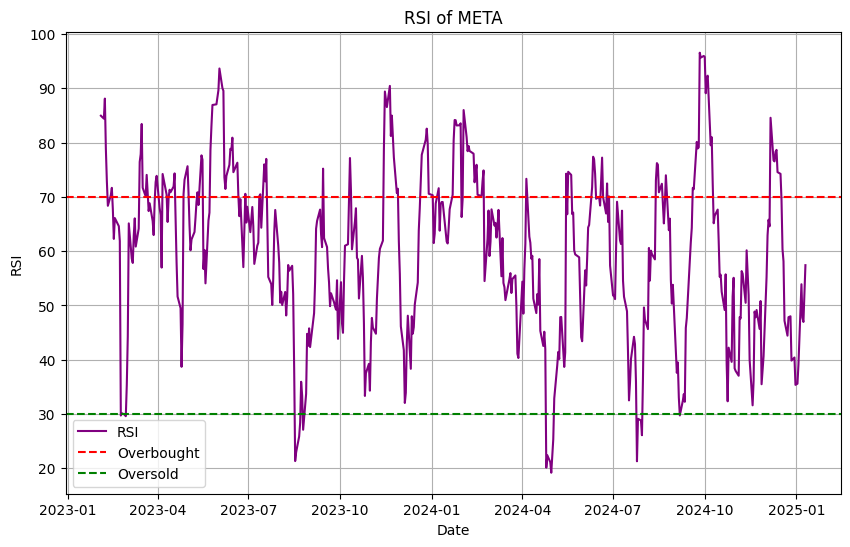

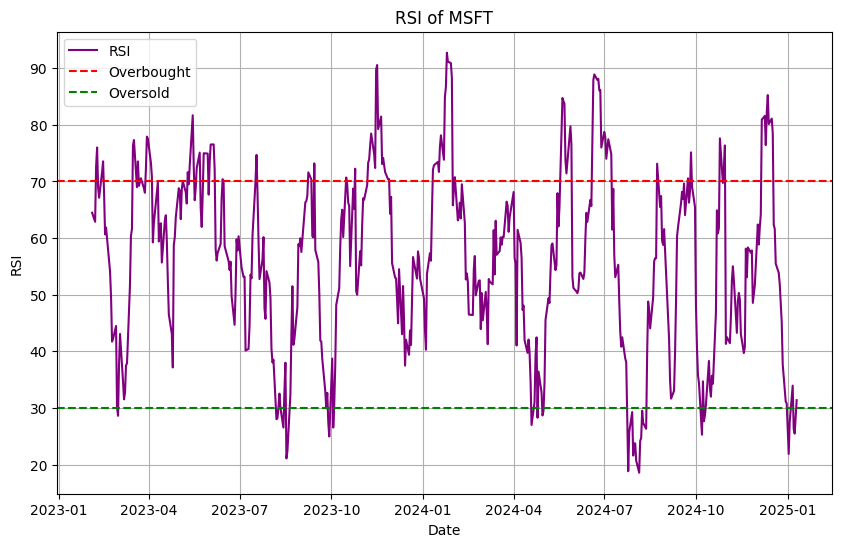

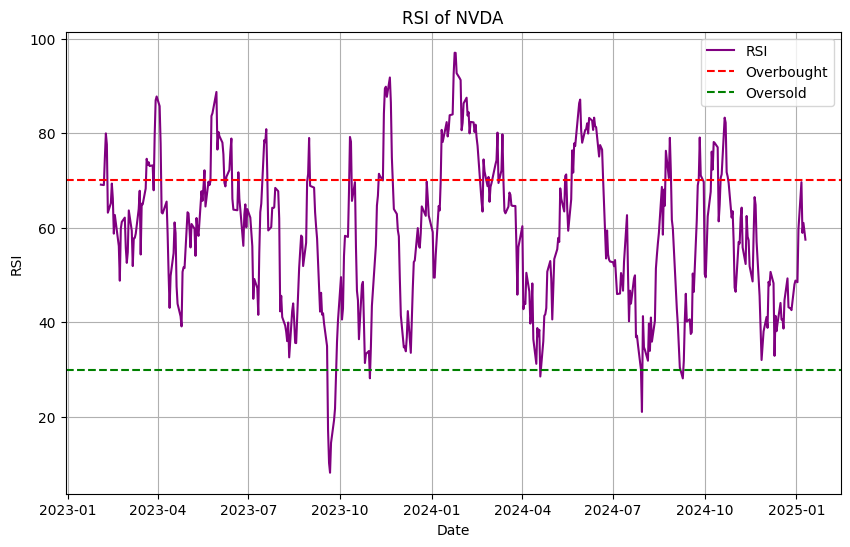

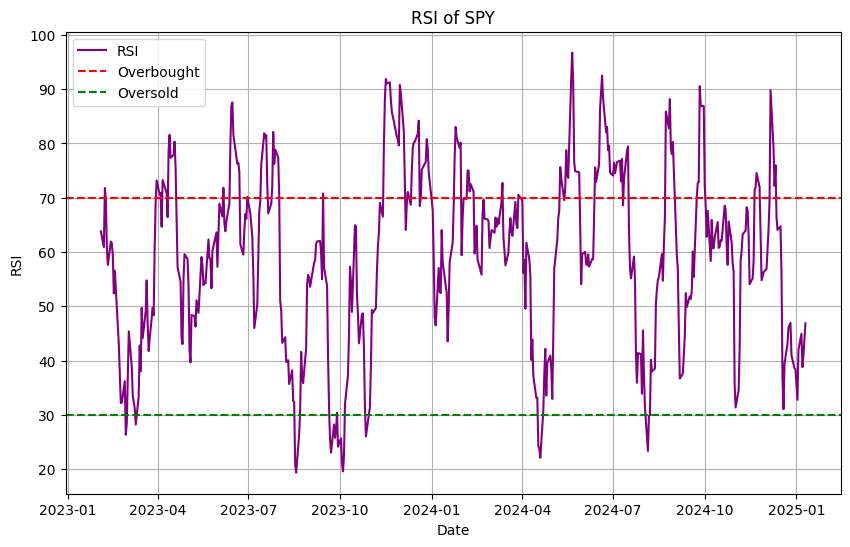

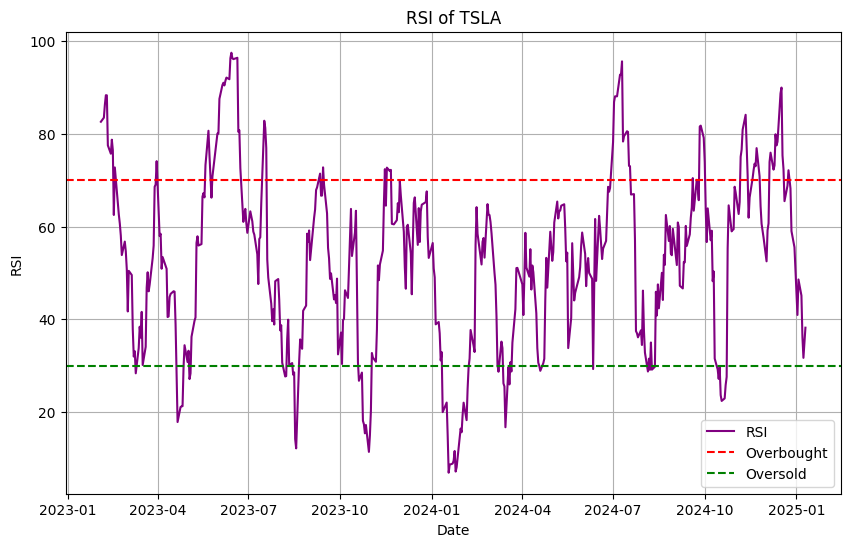

In [ ]:
for ticker in tickers:
  calculate_and_plot_rsi(ticker, start_date, end_date)

# Bollinger Bands

**What is it?** Bollinger Bands consist of a middle band (SMA) and two outer bands (standard deviations away from the SMA). They help identify volatility and potential overbought or oversold conditions.

**How to interpret?** When the price touches the upper band, it may indicate that the stock is overbought. Conversely, touching the lower band may indicate that the stock is oversold.

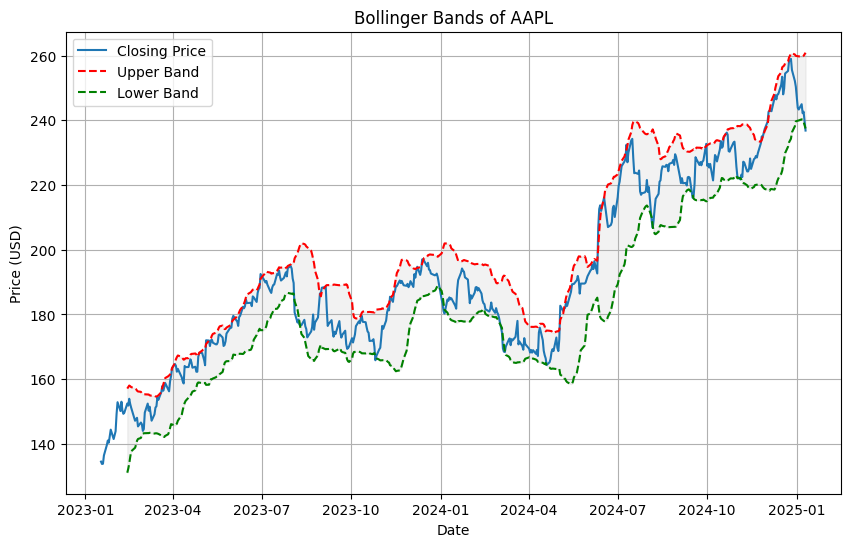

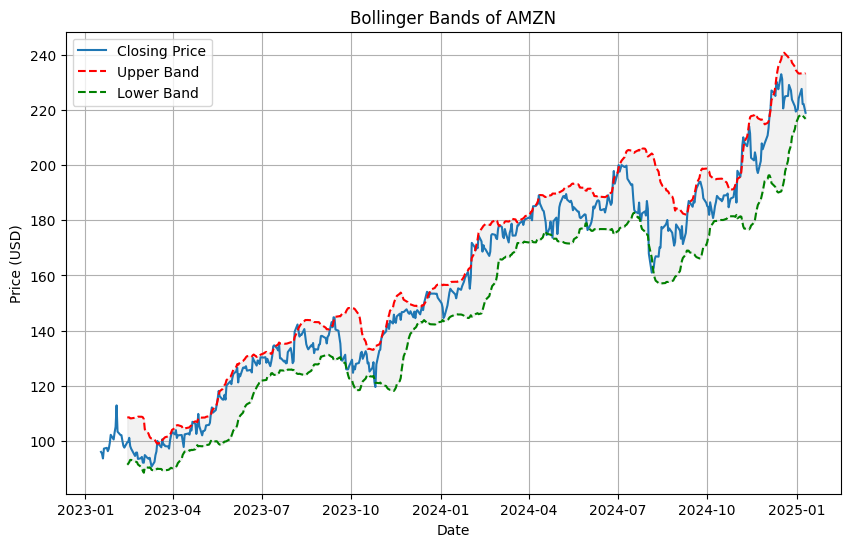

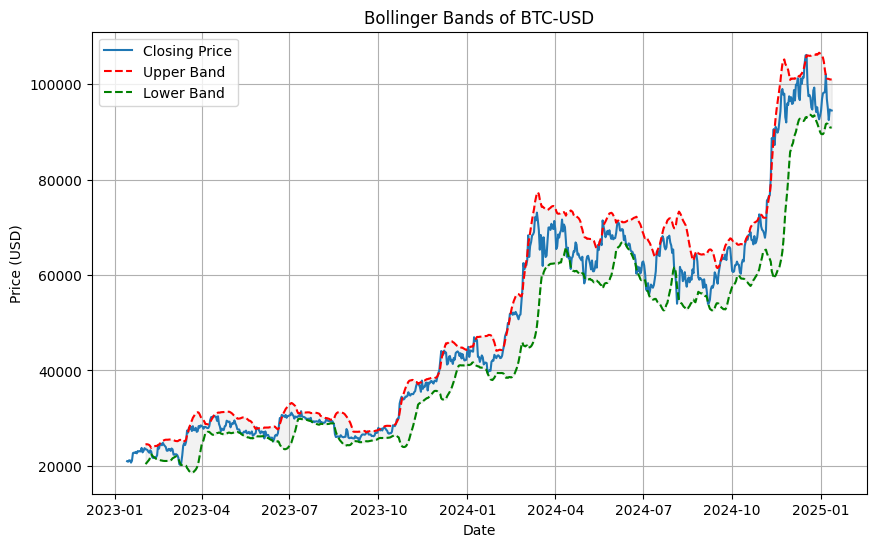

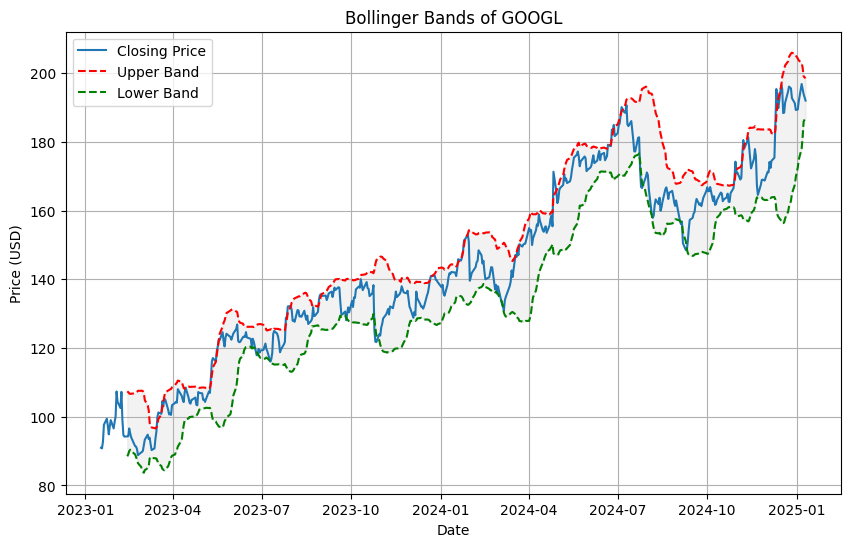

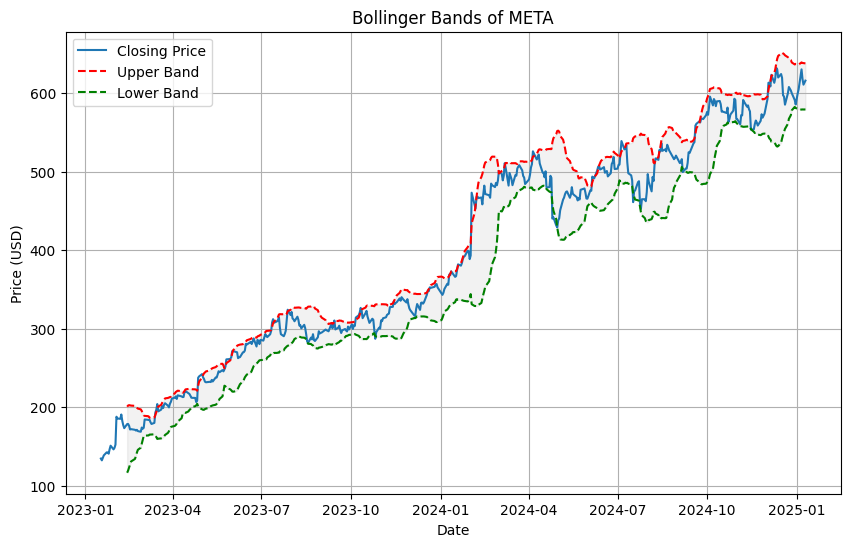

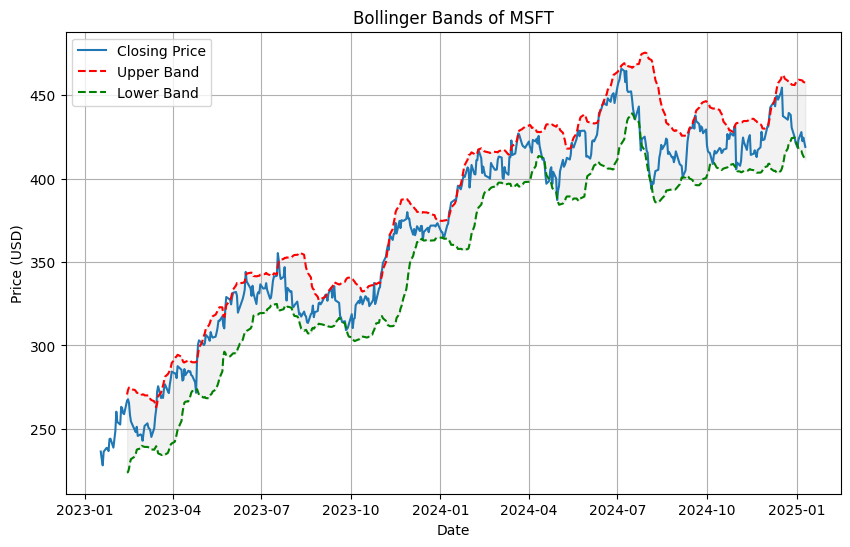

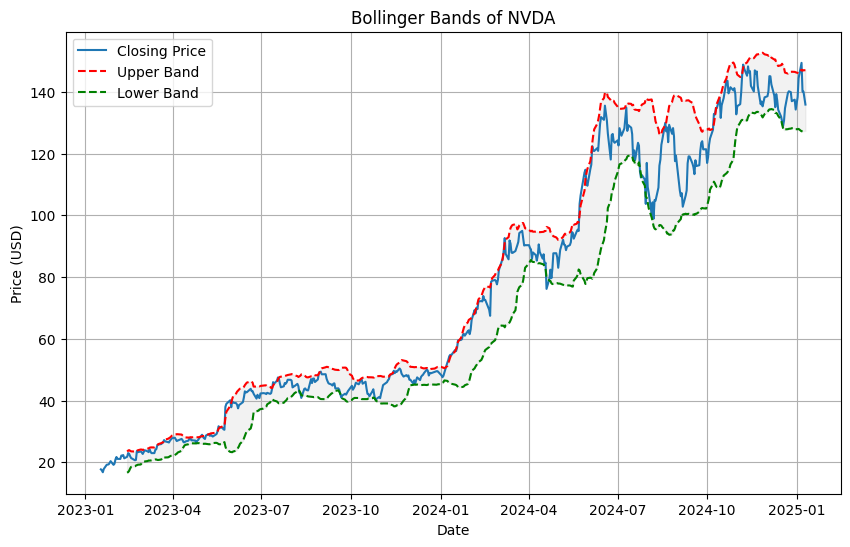

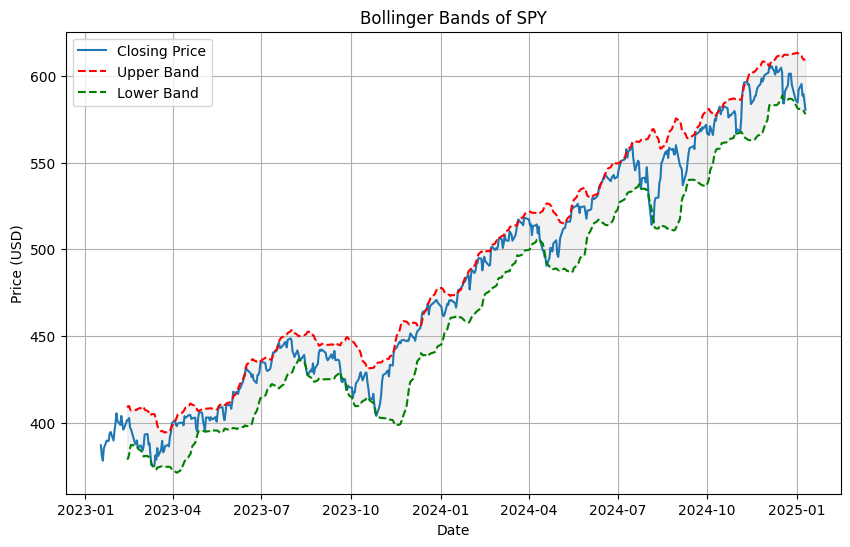

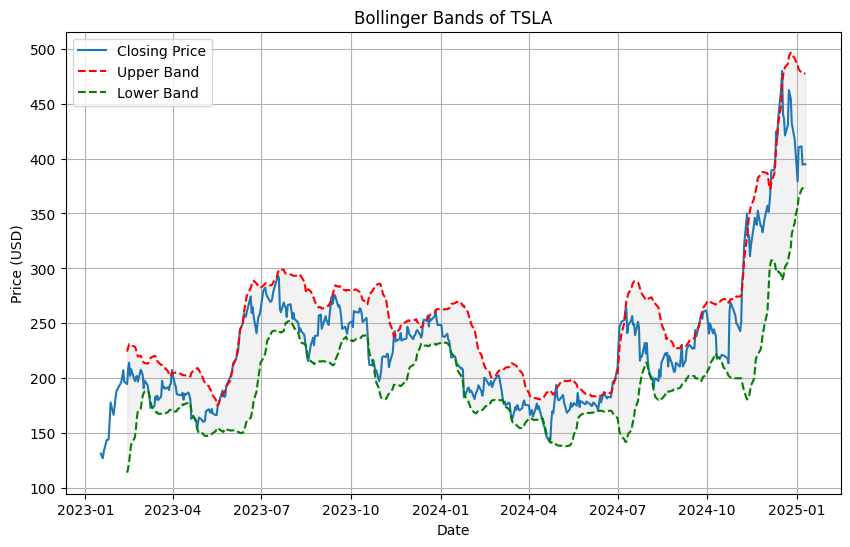

In [ ]:
for ticker in tickers:
  calculate_and_plot_bollinger_bands(ticker, start_date, end_date)

# Closing Price

**What is it?** The closing price is the last price at which a stock is traded during a regular trading session. It is a fundamental indicator of a stock's daily performance.

**How to interpret?**
 A current ratio above 1 suggests that the company has more current assets than current liabilities, indicating good short-term financial health.

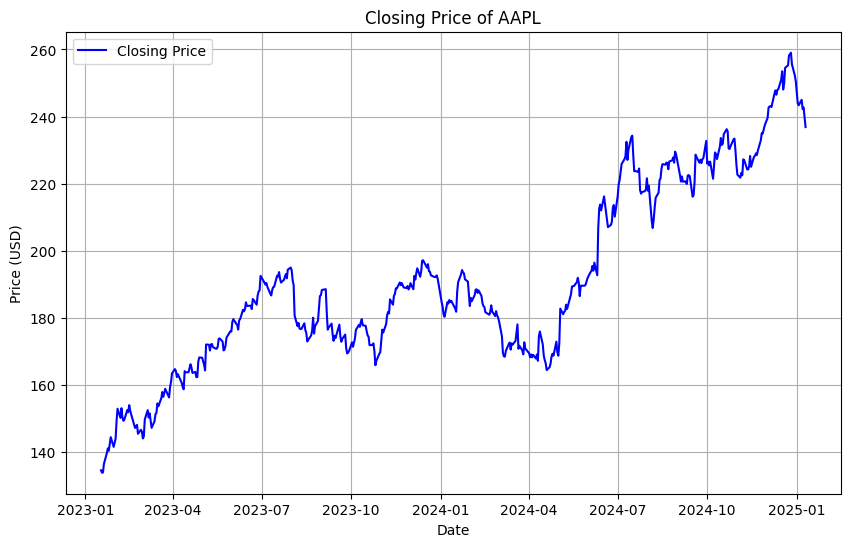

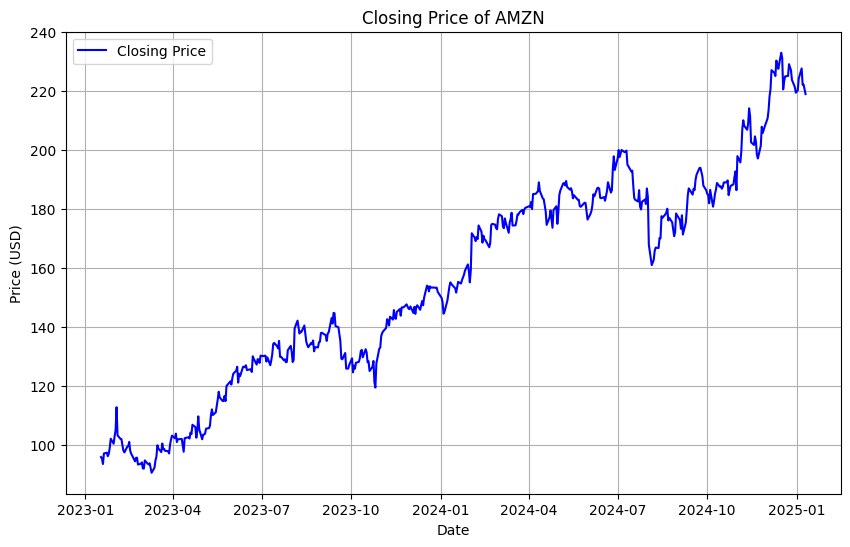

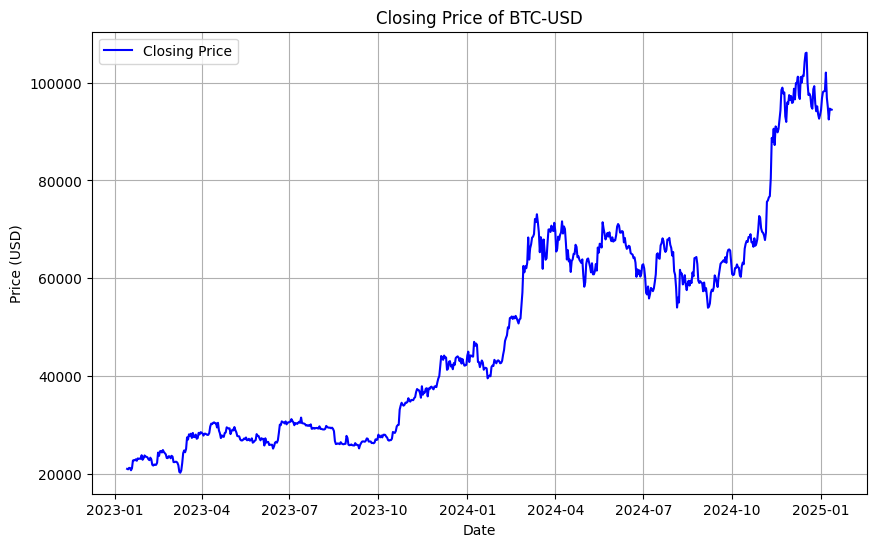

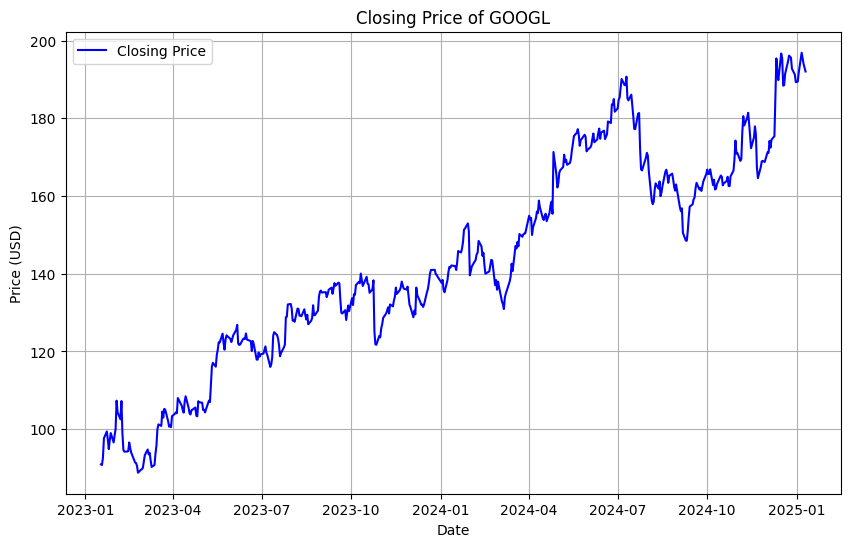

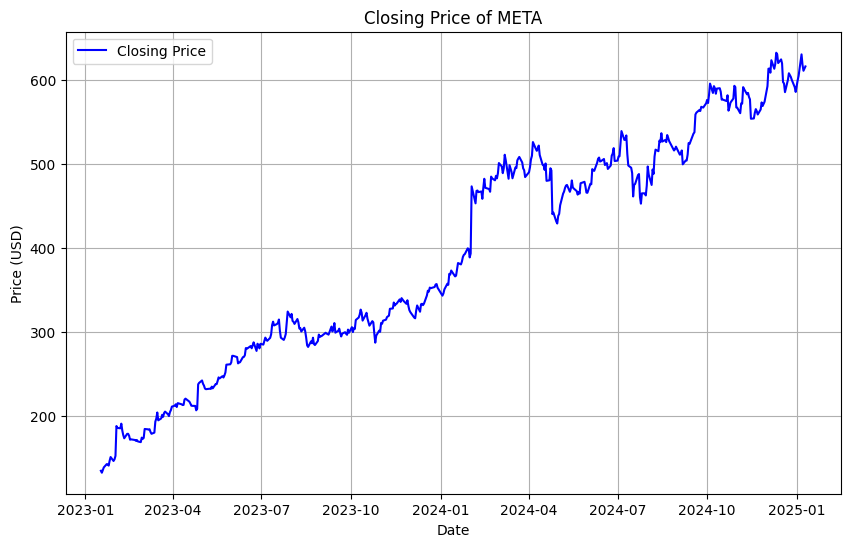

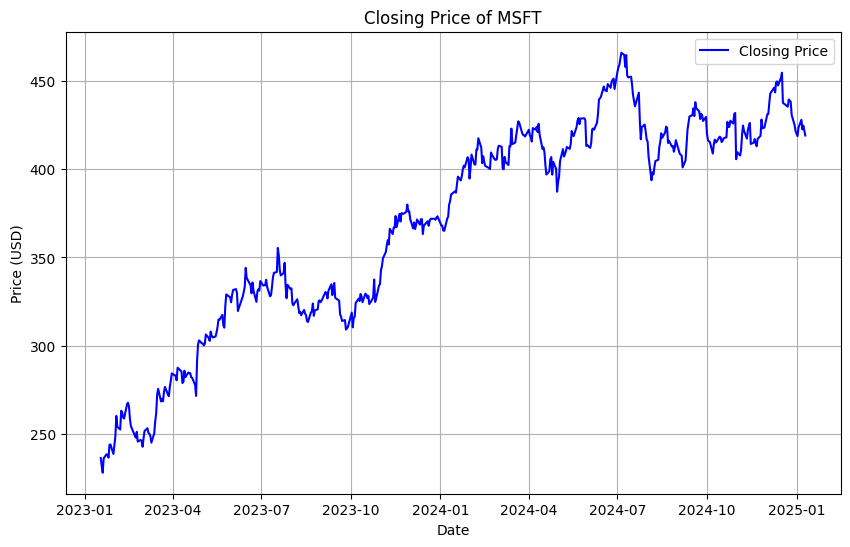

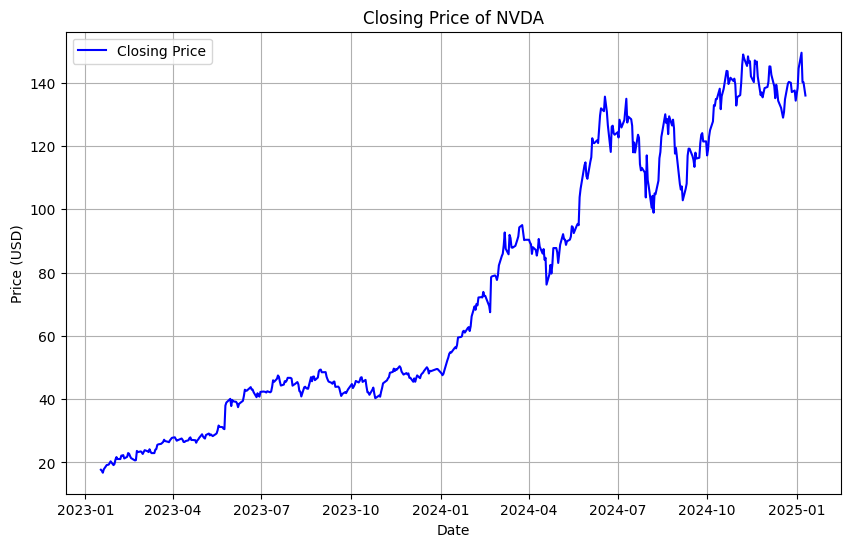

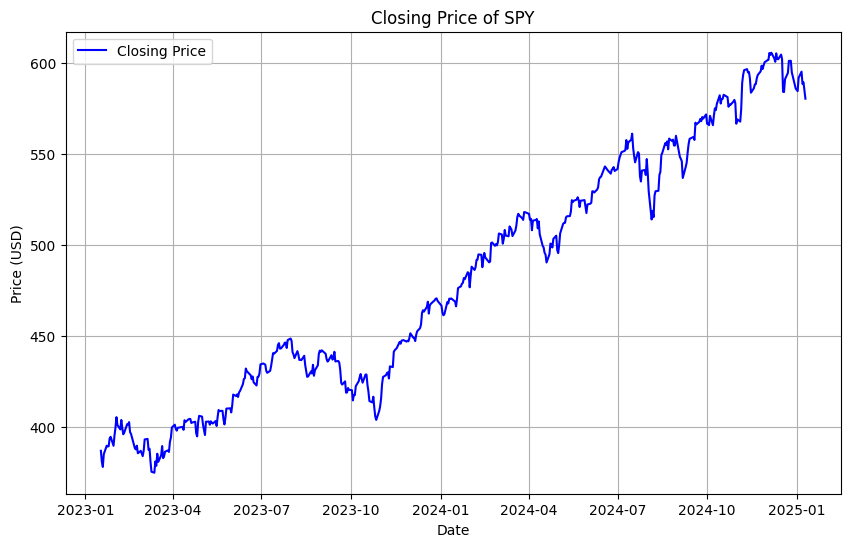

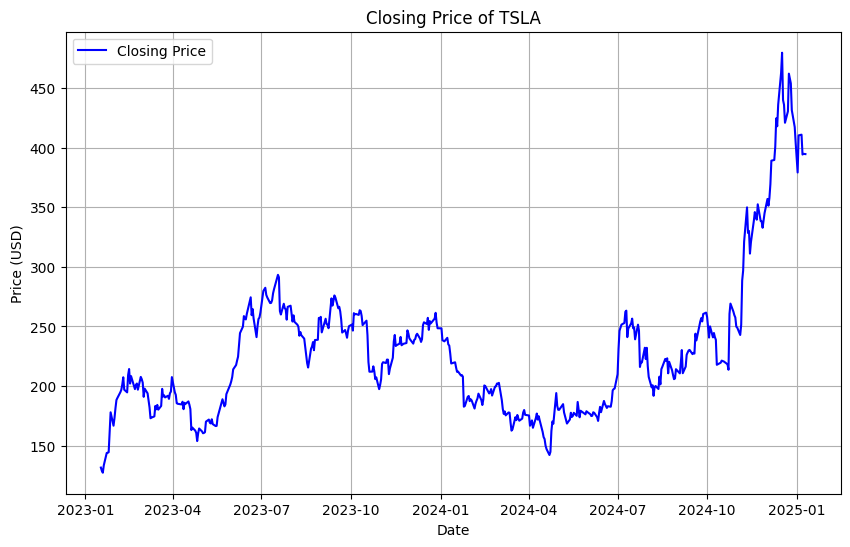

In [ ]:
for ticker in tickers:
  plot_closing_price(ticker, start_date, end_date)

###  Price-to-Earnings Ratio (P/E Ratio)

**What is it?** The P/E ratio measures a company's current share price relative to its per-share earnings. It is calculated by dividing the market value per share by the earnings per share (EPS)

**How to interpret it?**
A P/B ratio under 1 might suggest that a stock is undervalued, while a ratio over 1 could indicate overvaluation.

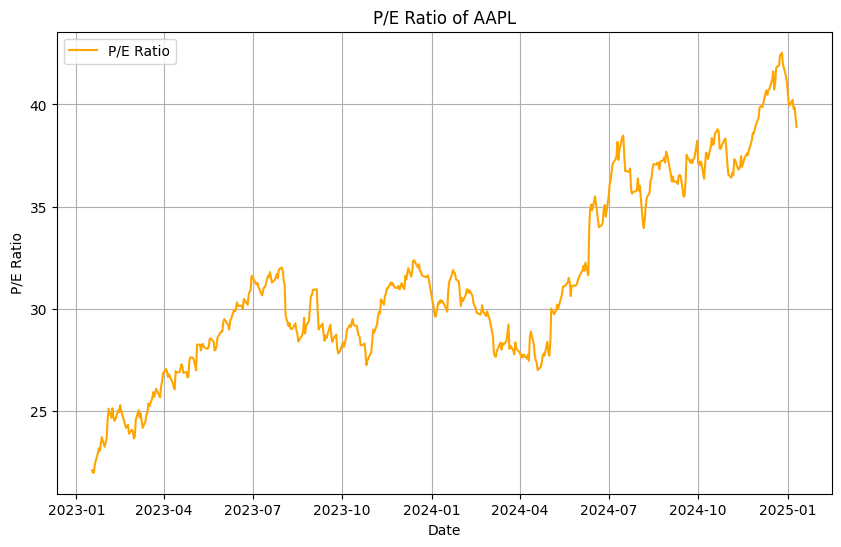

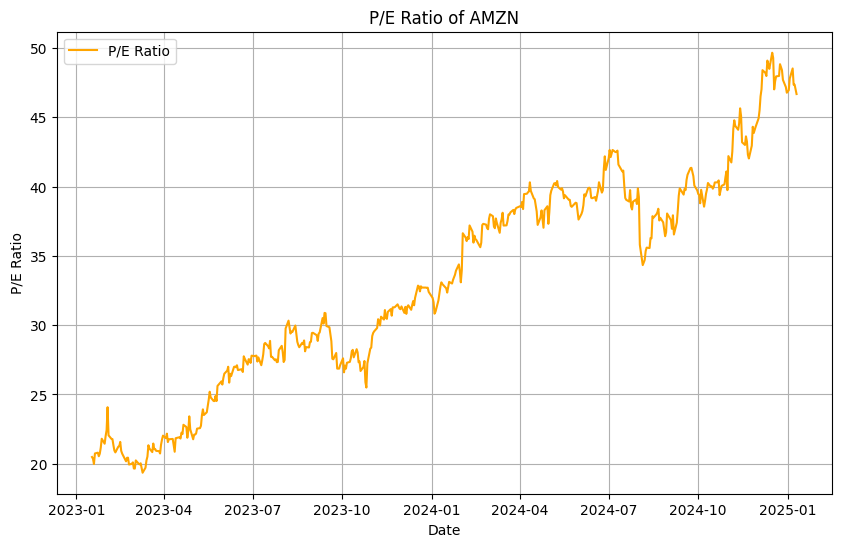

P/E Ratio for BTC-USD could not be calculated (EPS unavailable).


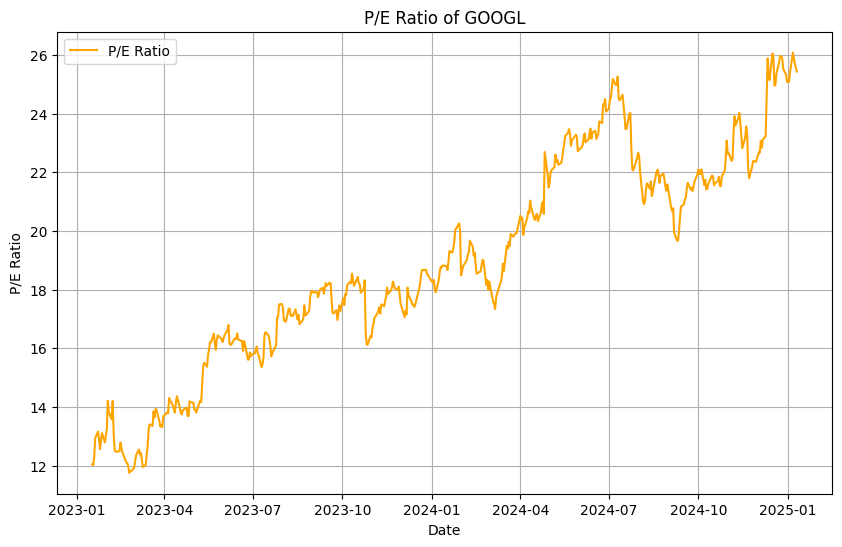

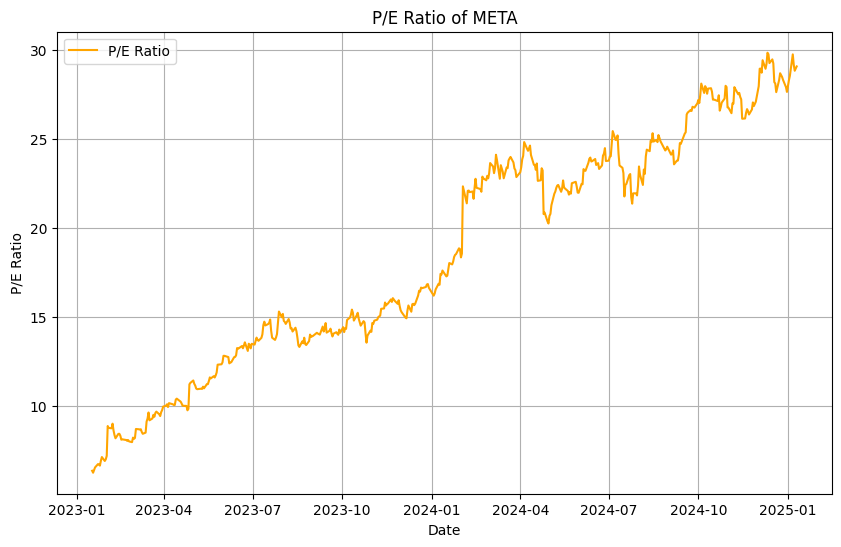

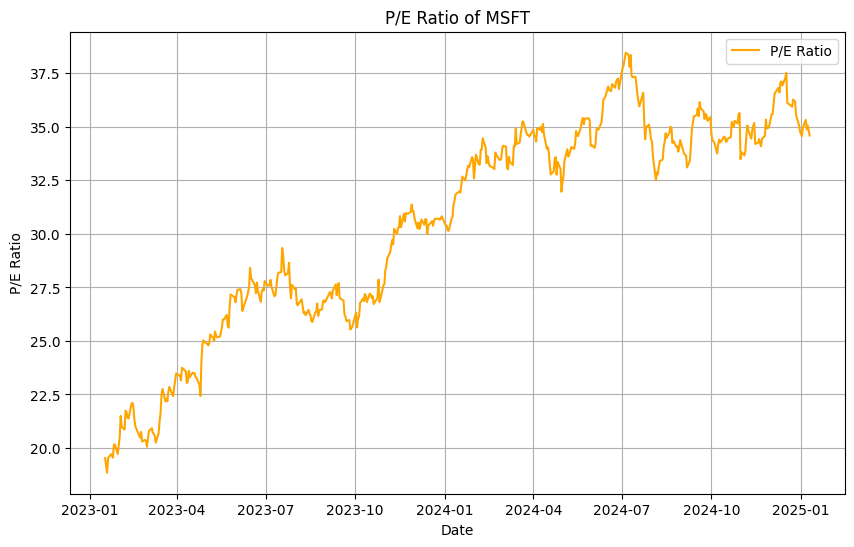

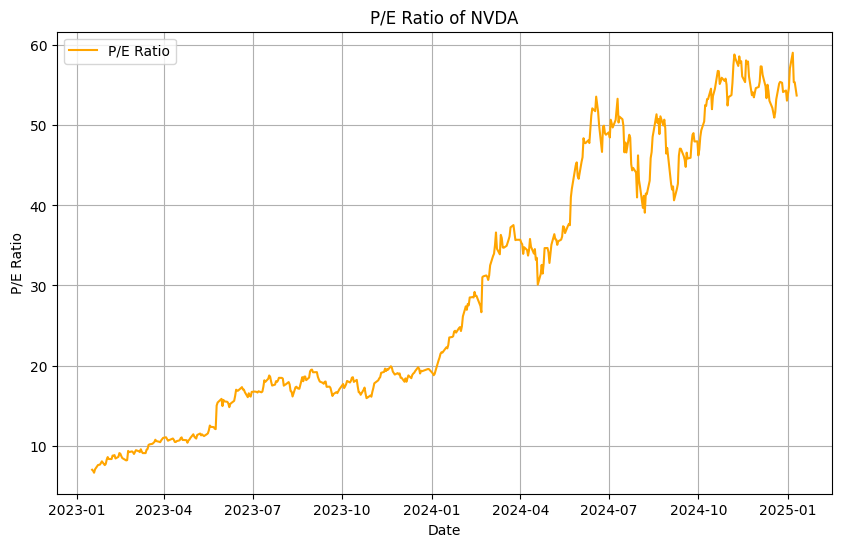

P/E Ratio for SPY could not be calculated (EPS unavailable).


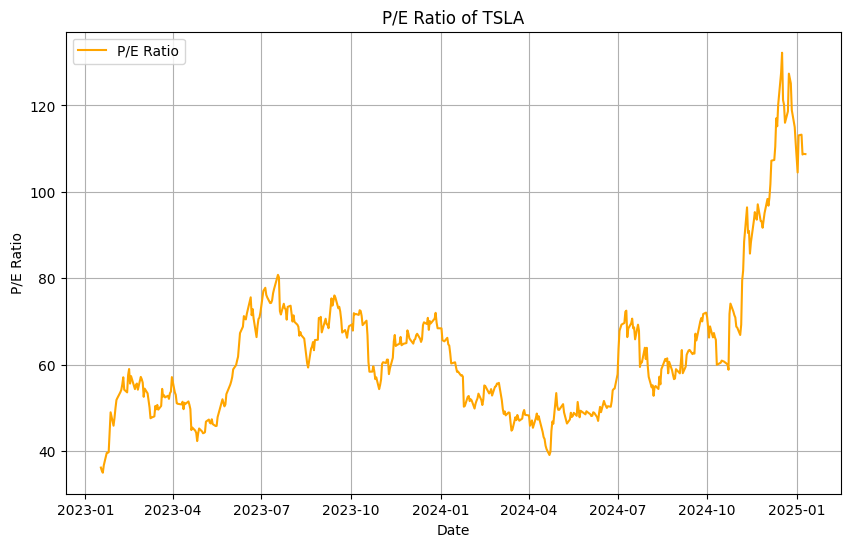

In [ ]:
for ticker in tickers:
  calculate_and_plot_pe_ratio(ticker, start_date, end_date)

# Beta

**What is it?** Beta measures a stock's volatility in relation to the overall market.

**How to interpret?** A beta greater than 1 indicates that the stock is more volatile than the market, while a beta less than 1 suggests less volatility.


Beta value for BTC-USD is not available.
Beta value for SPY is not available.


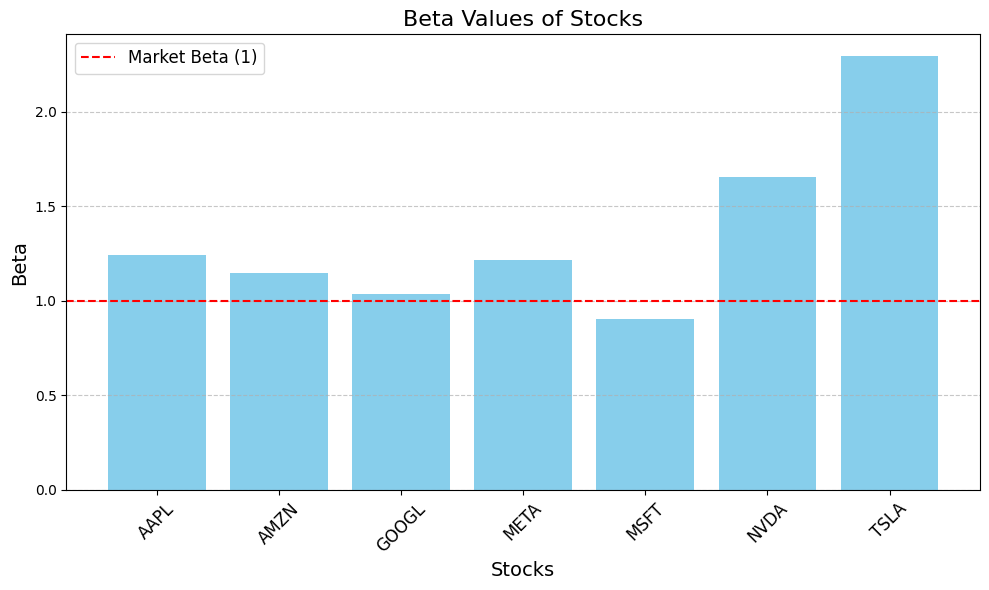

In [ ]:
plot_beta(tickers)

In [ ]:
# Calculate KPIs for the defined tickers and date range
kpi_data = calculate_all_kpis(tickers, start_date, end_date)

In [ ]:
# Create a prompt to generate an executive summary with recommendations based on KPI data
prompt = f""" Read this data {kpi_data} and provide an summary with recommendations"""

In [ ]:
# Get the response from the LLM based on the provided prompt
get_llm_response(llm = llm, prompt = prompt)

Based on the provided data, here's a summary and some general recommendations for each asset:

### AAPL (Apple Inc.)
- **Closing Price**: The price has shown a significant upward trend from around $134 in early 2023 to $234 in early 2025.
- **RSI**: The RSI is below 30, indicating that the stock might be oversold, which could be a potential buying opportunity.
- **Bollinger Bands**: The current price is below the SMA and approaching the lower band, suggesting potential undervaluation.
- **P/E Ratio**: The P/E ratio has increased from around 22 to 38, indicating higher market expectations or overvaluation.
- **Beta**: 1.24, suggesting higher volatility compared to the market.

**Recommendation**: Consider buying if you believe in Apple's long-term growth, but be cautious of the high P/E ratio.

### AMZN (Amazon.com Inc.)
- **Closing Price**: The price has increased from around $96 to $218.
- **RSI**: The RSI is around 42, indicating a neutral position.
- **Bollinger Bands**: The price is near the lower band, suggesting potential undervaluation.
- **P/E Ratio**: The P/E ratio has increased significantly, indicating potential overvaluation.
- **Beta**: 1.146, indicating moderate volatility.

**Recommendation**: Hold or buy if you expect continued growth, but be cautious of the high P/E ratio.

### BTC-USD (Bitcoin)
- **Closing Price**: The price has increased significantly from around $20,880 to $94,488.
- **RSI**: The RSI is around 52, indicating a neutral position.
- **Bollinger Bands**: The price is within the bands, suggesting no immediate overvaluation or undervaluation.
- **P/E Ratio**: Not applicable.
- **Beta**: Not applicable.

**Recommendation**: Consider holding if you believe in Bitcoin's long-term potential, but be aware of its inherent volatility.

### GOOGL (Alphabet Inc.)
- **Closing Price**: The price has increased from around $90 to $191.
- **RSI**: The RSI is around 54, indicating a neutral position.
- **Bollinger Bands**: The price is within the bands, suggesting no immediate overvaluation or undervaluation.
- **P/E Ratio**: The P/E ratio has increased, indicating potential overvaluation.
- **Beta**: 1.034, indicating moderate volatility.

**Recommendation**: Hold or buy if you expect continued growth, but be cautious of the high P/E ratio.

### META (Meta Platforms Inc.)
- **Closing Price**: The price has increased from around $134 to $608.
- **RSI**: The RSI is around 55, indicating a neutral position.
- **Bollinger Bands**: The price is within the bands, suggesting no immediate overvaluation or undervaluation.
- **P/E Ratio**: The P/E ratio has increased significantly, indicating potential overvaluation.
- **Beta**: 1.215, indicating higher volatility.

**Recommendation**: Consider holding if you believe in Meta's long-term potential, but be cautious of the high P/E ratio.

### MSFT (Microsoft Corporation)
- **Closing Price**: The price has increased from around $236 to $417.
- **RSI**: The RSI is around 31, indicating potential oversold conditions.
- **Bollinger Bands**: The price is near the lower band, suggesting potential undervaluation.
- **P/E Ratio**: The P/E ratio has increased, indicating potential overvaluation.
- **Beta**: 0.904, indicating lower volatility.

**Recommendation**: Consider buying if you believe in Microsoft's long-term growth, especially given the low RSI.

### NVDA (NVIDIA Corporation)
- **Closing Price**: The price has increased from around $17 to $133.
- **RSI**: The RSI is around 53, indicating a neutral position.
- **Bollinger Bands**: The price is within the bands, suggesting no immediate overvaluation or undervaluation.
- **P/E Ratio**: The P/E ratio has increased significantly, indicating potential overvaluation.
- **Beta**: 1.657, indicating higher volatility.

**Recommendation**: Consider holding if you believe in NVIDIA's long-term potential, but be cautious of the high P/E ratio.

### SPY (S&P 500 ETF)
- **Closing Price**: The price has increased from around $386 to $581.
- **RSI**: The RSI is around 48, indicating a neutral position.
- **Bollinger Bands**: The price is within the bands, suggesting no immediate overvaluation or undervaluation.
- **P/E Ratio**: Not applicable.
- **Beta**: Not applicable.

**Recommendation**: Consider holding as a diversified investment in the broader market.

### TSLA (Tesla Inc.)
- **Closing Price**: The price has increased from around $131 to $403.
- **RSI**: The RSI is around 42, indicating a neutral position.
- **Bollinger Bands**: The price is within the bands, suggesting no immediate overvaluation or undervaluation.
- **P/E Ratio**: The P/E ratio has increased significantly, indicating potential overvaluation.
- **Beta**: 2.295, indicating very high volatility.

**Recommendation**: Consider holding if you believe in Tesla's long-term potential, but be cautious of the high P/E ratio and volatility.

### General Recommendations:
- **Diversification**: Consider diversifying your portfolio to manage risk.
- **Market Conditions**: Keep an eye on broader market conditions and economic indicators.
- **Long-term Perspective**: Focus on long-term growth potential rather than short-term fluctuations.
- **Risk Tolerance**: Align your investments with your risk tolerance and financial goals.

"Based on the provided data, here's a summary and some general recommendations for each asset:\n\n### AAPL (Apple Inc.)\n- **Closing Price**: The price has shown a significant upward trend from around $134 in early 2023 to $234 in early 2025.\n- **RSI**: The RSI is below 30, indicating that the stock might be oversold, which could be a potential buying opportunity.\n- **Bollinger Bands**: The current price is below the SMA and approaching the lower band, suggesting potential undervaluation.\n- **P/E Ratio**: The P/E ratio has increased from around 22 to 38, indicating higher market expectations or overvaluation.\n- **Beta**: 1.24, suggesting higher volatility compared to the market.\n\n**Recommendation**: Consider buying if you believe in Apple's long-term growth, but be cautious of the high P/E ratio.\n\n### AMZN (Amazon.com Inc.)\n- **Closing Price**: The price has increased from around $96 to $218.\n- **RSI**: The RSI is around 42, indicating a neutral position.\n- **Bollinger Bands

# Modern Portfolio Theory

Modern Portfolio Theory (MPT) is a financial theory developed by Harry Markowitz in the 1950s, which aims to optimize the balance between risk and return in an investment portfolio. The core idea of MPT is that an investor can construct a portfolio of multiple assets that will maximize returns for a given level of risk, or equivalently, minimize risk for a given level of expected return. This is achieved through diversification, which reduces the overall risk of the portfolio by combining assets that do not perfectly correlate with each other.

In [ ]:
# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

# Function to calculate the negative Sharpe ratio
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std

# Function to find the portfolio with the maximum Sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_weights = [1. / num_assets] * num_assets

    # Perform optimization
    result = minimize(negative_sharpe_ratio, initial_weights, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    # Debugging: Print the optimization result
    print("Optimization Result:", result)

    return result

# Fetch the adjusted close prices for the tickers
data = yf.download(tickers, start=start_date, end=end_date).dropna()

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Debugging: Print mean returns and covariance matrix
print("Mean Returns:\n", mean_returns)
print("Covariance Matrix:\n", cov_matrix)

# Risk-free rate
risk_free_rate = 0.01  # Adjusted to 1%

# Optimize the portfolio for maximum Sharpe ratio
optimal_portfolio = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_portfolio.x

# Store the optimal weights in a dictionary and print the result
weights_dict = {tickers[i]: round(optimal_weights[i], 2) for i in range(len(tickers))}
print("Optimized Portfolio Weights:", weights_dict)


[*********************100%***********************]  9 of 9 completed


Mean Returns:
 Price   Ticker 
Close   AAPL       0.001515
        AMZN       0.002082
        BTC-USD    0.003966
        GOOGL      0.001705
        META       0.003401
        MSFT       0.001281
        NVDA       0.005028
        SPY        0.000958
        TSLA       0.003369
High    AAPL       0.001428
        AMZN       0.002040
        BTC-USD    0.003913
        GOOGL      0.001658
        META       0.003404
        MSFT       0.001228
        NVDA       0.004898
        SPY        0.000933
        TSLA       0.003116
Low     AAPL       0.001521
        AMZN       0.002084
        BTC-USD    0.003879
        GOOGL      0.001684
        META       0.003399
        MSFT       0.001273
        NVDA       0.004946
        SPY        0.000957
        TSLA       0.003333
Open    AAPL       0.001449
        AMZN       0.002092
        BTC-USD    0.003937
        GOOGL      0.001686
        META       0.003457
        MSFT       0.001266
        NVDA       0.004944
        SPY      

In [ ]:
data = yf.download(tickers, start=start_date, end=end_date).dropna()

# Daily returns
returns = data.pct_change().dropna()

# Annualize mean returns and covariance matrix
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6

# Risk-free rate
risk_free_rate = 0.04

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

# Function to calculate the negative Sharpe ratio
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std

# Function to find the portfolio with the maximum Sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.01, 1) for asset in range(num_assets))  # Minimum weight of 1%
    initial_weights = [1. / num_assets] * num_assets

    # Perform optimization
    result = minimize(negative_sharpe_ratio, initial_weights, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Optimize portfolio
optimal_portfolio = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_portfolio.x

weights_dict = {tickers[i]: round(optimal_weights[i], 2) for i in range(len(tickers))}
print("Optimized Portfolio Weights:", weights_dict)


[*********************100%***********************]  9 of 9 completed


Optimized Portfolio Weights: {'AAPL': 0.01, 'AMZN': 0.01, 'BTC-USD': 0.01, 'GOOGL': 0.01, 'META': 0.01, 'MSFT': 0.01, 'NVDA': 0.05, 'SPY': 0.01, 'TSLA': 0.01}


# Black Litterman Model

The Black-Litterman Model is a portfolio optimization framework that combines the Modern Portfolio Theory (MPT) with investor views to create more realistic and intuitive portfolio allocations.


In [ ]:
risk_free_rate = 0.001

# Fetch historical stock data
df = yf.download(tickers, start=start_date, end=end_date)['Close']
df  = df.dropna()

# Calculate the sample mean returns and the covariance matrix
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Define market capitalizations
mcap = {}
for ticker in tickers:
  stock = yf.Ticker(ticker)
  try:
    mcap[ticker] = stock.info['marketCap']
  except KeyError:
    mcap[ticker] = None

# Manually set the market capitalization for the S&P 500 index (SPY)
mcap['SPY'] = 45000000000000

mcap = pd.Series(mcap).dropna()
mcap /= mcap.sum()

# Define beliefs (Microsoft will outperform Google by 5%)
Q = np.array([0.05])
P = np.zeros((1, len(tickers)))
P[0, tickers.index('MSFT')] = 1
P[0, tickers.index('GOOGL')] = -1

# Calculate the market implied returns
market_prices = df["SPY"]
delta = black_litterman.market_implied_risk_aversion(market_prices)
market_prior = black_litterman.market_implied_prior_returns(mcap, delta, S, risk_free_rate)

# Create the Black-Litterman model
bl = BlackLittermanModel(S,
                         Q  = Q,
                         P = P,
                         pi = market_prior,
                         market_weights = market_prior,
                         risk_free_rate = risk_free_rate)

# Get the adjusted returns and covariance matrix
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

# Optimize the portfolio for maximum Sharpe ratio
ef = EfficientFrontier(bl_returns, bl_cov)
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()

print(cleaned_weights)
ef.portfolio_performance(verbose=True)



[*********************100%***********************]  9 of 9 completed


OrderedDict([('AAPL', 0.05271), ('AMZN', 0.03235), ('BTC-USD', 0.02925), ('GOOGL', 0.0), ('META', 0.02222), ('MSFT', 0.09719), ('NVDA', 0.05092), ('SPY', 0.69514), ('TSLA', 0.02021)])
Expected annual return: 34.2%
Annual volatility: 15.6%
Sharpe Ratio: 2.18


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.34179594791993173, 0.15624033128710352, 2.1812290406226365)